<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/LH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install / import / def

### 글꼴 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


### import : for modeling
- MyChartPlotHistory(history)
- tensorflow, pandas, numpy, matplotlib, seaborn, keras

In [ ]:
# from keras.datasets import fashion_mnist
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img    # keras 이미지 전처리를 위한 클래스

# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 는 tensorflow에 있는 데이터로만 가능
import os           # dir 읽어서 올림
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

import warnings
warnings.filterwarnings(action="ignore")

np.random.seed(121)
tf.random.set_seed(121)

In [ ]:
def MyChartPlotHistory(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],    label='acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'val_acc')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],    label = 'loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'val_loss')
    plt.legend()
    plt.show()

### import: for map
- install pydeck, mip, geopandas
- sharply, geopandas

In [ ]:
pip install pydeck

In [ ]:
pip install mip

In [ ]:
pip install geopandas

In [ ]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

# import pandas as pd
import geopandas as gpd
import folium
import shapely
# import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sklearn.cluster
# import tensorflow as tf

#from geoband import API

import pydeck as pdk
import os

import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'Nanum Gothic'
plt.rc('font', family='NanumBarunGothic') 

from shapely.geometry import Polygon, Point
from numpy import random

#최적화 solver
import time
from mip import Model, xsum, maximize, BINARY  

In [ ]:
#Pydeck 사용을 위한 함수 정의
import geopandas as gpd 
import shapely # Shapely 형태의 데이터를 받아 내부 좌표들을 List안에 반환합니다. 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

In [ ]:
def geo_to_df(df_whatwillread, na_col=None, norm_col=None, geotype='multipoligon'):

    # 격자별 인구 현황
    # df_08= gpd.read_file("../../data/GY/input/08.광양시_격자별인구현황(100X100).geojson")  --> df
    df_08 = df_whatwillread

    # val 열 na 제거
    if na_col != None:
      df_08[na_col] = df_08[na_col].fillna(0)


    # 인구 수 정규화
    if norm_col != None:
      df_08['정규화'] = df_08[norm_col] / df_08[norm_col].max()

    # geotype == 'multipoligon'
    if geotype == 'multipoligon':
      # geometry를 coordinate 형태로 적용
      df_08['coordinates'] = df_08['geometry'].apply(multipolygon_to_coordinates) #pydeck 을 위한 coordinate type
    elif geotype == 'multilinestring':
      df_08['coordinates'] = df_08['geometry'].apply(line_string_to_coordinates) 
    elif geotype == 'polygon':
      df_08['coordinates'] = df_08['geometry'].apply(polygon_to_coordinates)
    elif geotype == 'multipoint':
      df_08['coordinates'] = df_08['geometry'].apply(multipoint_to_coordinates)        

    # 100X100 grid에서 central point 찾기
    df_08_list = []
    df_08_list2 = []
    for i in df_08['geometry']:
        cent = [[i[0].centroid.coords[0][0],i[0].centroid.coords[0][1]]]
        df_08_list.append(cent)
        df_08_list2.append(Point(cent[0]))
    df_08['coord_cent'] = 0
    df_08['geo_cent'] = 0
    df_08['coord_cent']= pd.DataFrame(df_08_list) # pydeck을 위한 coordinate type
    df_08['geo_cent'] = df_08_list2 # geopandas를 위한 geometry type


    # 쉬운 분석을 위한 임의의 grid id 부여
    df_08['grid_id']=0
    idx = []
    for i in range(len(df_08)):
        idx.append(str(i).zfill(5))
    df_08['grid_id'] = pd.DataFrame(idx)

## Data

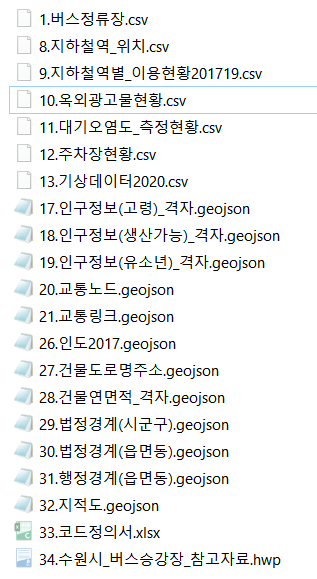
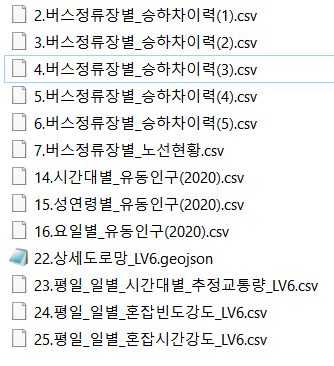

요일별 생략 가능 -> 시간대별 데이터 나눠서 사용


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
colab_path = '/content/drive/MyDrive/Colab Notebooks/data/LH/'
# colab_path = '/content/drive/MyDrive/data/LH/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## From COMPAS

### input parameter type - 실행X(참고용)


type name|Description
-|-	
feature_name|feature 명. <br>공간연산에 필요한 feature 목록을 compas에서 제공합니다.<br>feature_name에는 반드시 compas에서 제공된 목록에 있는 feature 명만 사용 가능합니다.
feature_list|feture 이름 List.<br>공간연산시 여러 개의 feature가 필요한 경우 콤마(,)를 구분자로 해서 feature_list를 API에 제공해야 합니다.
cql|	Casandra Query Languate
GeoJSON|	위치정보를 갖는 점을 기반으로 체계적으로 지형을 표현하기 위해 설계된 개방형 공개 표준 형식.
boolean	|True / False

4  Sample Featrues Data
Geoband 에서 제공하는 Feature 데이타 입니다. 공간분석시 사용가능합니다.
API 호출시 Feature Name을 사용하시기 바랍니다.

Type	|Title	|Feature Name	|SRS
-|-|-|-
Polygon	|시도	|geoband:tl_scco_ctprvn	|EPSG:4326
Polygon	|시군구	|geoband:tl_scco_sig	|EPSG:4326
Polygon	|리	|geoband:tl_scco_li	|EPSG:4326
Polygon	|읍면동	|geoband:tl_scco_emd	|EPSG:4326
Point	|녹시율(부산)	|geoband:gvi_busan	|EPSG:4326
Point	|녹시율(대구)	|geoband:gvi_daegu	|EPSG:4326
Point	|녹시율(광주)	|geoband:gvi_gwangju	|EPSG:4326
Point	|녹시율(화성)	|geoband:gvi_hwaseong	|EPSG:4326
Point	|녹시율(인천)	|geoband:gvi_incheon	|EPSG:4326
Point	|녹시율(세종)	|geoband:gvi_sejong	|EPSG:4326
Point	|녹시율(서울)	|geoband:gvi_seoul	|EPSG:4326
Point	|녹시율(울산)	|geoband:gvi_ulsan	|EPSG:4326
Point	|서울시 아파트	|geoband:apartment	|EPSG:4326
Point	|전국 은행	|geoband:bank	|EPSG:4326
Point	|전국 버거킹	|geoband:bugerking	|EPSG:4326
Point	|전국 던킨도너츠	|geoband:dunkindonuts	|EPSG:4326
Point	|전국 지진	|geoband:earthquake	|EPSG:3857
Polygon	|서울시 동	|geoband:emd	|EPSG:3857
Point	|전국 대기업	|geoband:enterprise	|EPSG:3857
Point	|전국 소방서	|geoband:firestation	|EPSG:3857
Point	|서울시 가스충전소	|geoband:gasstation	|EPSG:3857
Point	|전국 골프장	|geoband:golf	|EPSG:3857
Point	|서울시 병원	|geoband:hospital	|EPSG:3857
Point	|전국 KFC	|geoband:kfc	|EPSG:3857
Polygon	|전국 읍면동	|geoband:korea_emd	|EPSG:3857
Point	|전국 학교	|geoband:korea_school	|EPSG:3857
Polygon	|전국 시군구	|geoband:korea_sgg	|EPSG:3857
Line	|서울시 샘플 라인	|geoband:line	|EPSG:3857
Point	|전국 롯데리아	|geoband:lotteria	|EPSG:3857
Point	|서울시 재래시장	|geoband:market	|EPSG:3857
Point	|전국 맥도널드	|geoband:mcdonalds	|EPSG:3857
Point	|전국 아웃브레이크	|geoband:outbreak	|EPSG:3857
Line	|서울시 OD 데이터	|geoband:od_flow	|EPSG:3857
Polygon	|서울시 오버레이1	|geoband:overlay01	|EPSG:3857
Polygon	|서울시 오버레이2	|geoband:overlay02	|EPSG:3857
Point	|서울시 주점	|geoband:pubs	|EPSG:3857
Line	|서울시 도로망	|geoband:road	|EPSG:3857
Polygon	|서울 구별 인구 변화	|geoband:seoul_series	|EPSG:3857
Point	|서울시 학교	|geoband:school	|EPSG:3857
Polygon	|서울시 구	|geoband:sgg	|EPSG:3857
Polygon	|서울시 경계	|geoband:sid	|EPSG:3857
Point	|전국 철도역	|geoband:stations	|EPSG:3857
Point	|서울시 마트	|geoband:stores	|EPSG:3857
Point	|서울시 극장	|geoband:theaters	|EPSG:3857
Line	|전국 지하철노선	|geoband:subway	|EPSG:3857
Point	|서울시 위험 화학물 취급업소	|geoband:toxic_office	|EPSG:3857
Point	|서울시 추적점	|geoband:track_points	|EPSG:3857
Point	|서울시 구청	|geoband:wardoffice	|EPSG:3857

In [ ]:
from geoband.API import *

ModuleNotFoundError: ignored

### EDA

#### <b>df_승하차이력</b>: 버스정류장별 승하차이력(비공개)

In [ ]:
df_1 = pd.read_csv(colab_path + '2.버스정류장별_승하차이력(1).csv', encoding='utf-8')
df_2 = pd.read_csv(colab_path + '3.버스정류장별_승하차이력(2).csv', encoding='utf-8')
df_3 = pd.read_csv(colab_path + '4.버스정류장별_승하차이력(3).csv', encoding='utf-8')
df_4 = pd.read_csv(colab_path + '5.버스정류장별_승하차이력(4).csv', encoding='utf-8')
df_5 = pd.read_csv(colab_path + '6.버스정류장별_승하차이력(5).csv', encoding='utf-8')

In [ ]:
df_승하차이력 = df_1.append(df_2)
df_승하차이력 = df_승하차이력.append(df_3)
df_승하차이력 = df_승하차이력.append(df_4)
df_승하차이력 = df_승하차이력.append(df_5)

In [ ]:
# df_승하차이력.info()   # non-null

In [ ]:
# df_승하차이력.head()

In [ ]:
df_승하차이력['전체 승차 건수'] = df_승하차이력['전체 승차 건수'].astype(np.int32)
df_승하차이력['초승 건수']      = df_승하차이력['초승 건수'].astype(np.int32)
df_승하차이력['환승 건수']      = df_승하차이력['환승 건수'].astype(np.int32)
df_승하차이력['전체 하차 건수'] = df_승하차이력['전체 하차 건수'].astype(np.int32)
df_승하차이력['하차 건수']      = df_승하차이력['하차 건수'].astype(np.int32)
df_승하차이력['미태그 건수']    = df_승하차이력['미태그 건수'].astype(np.int32)

In [ ]:
df_승하차이력.drop('정류소명', axis=1, inplace=True)
df_승하차이력.drop('업체명', axis=1, inplace=True)

In [ ]:
# df_승하차이력.info()

In [ ]:
# df_승하차이력['노선유형'].unique()

In [ ]:
bus = ['직행좌석형시내버스', '일반형시내버스', '경기순환버스(직행좌석형)', '광역급행형시내버스', '좌석형시내버스',
       '맞춤형시내버스']

In [ ]:
def busbus(bus):
    num = 0
    if   bus == '직행좌석형시내버스': num = 0
    elif bus == '일반형시내버스': num = 1
    elif bus == '경기순환버스(직행좌석형)' : num = 2
    elif bus == '광역급행형시내버스' : num = 3
    elif bus == '좌석형시내버스' : num = 4
    else: num = 5
    return num

In [ ]:
df_승하차이력['노선유형'] = df_승하차이력['노선유형'].apply(lambda x : busbus(x))

In [ ]:
df_승하차이력.head()

,일자,노선번호,노선유형,정류소ID,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수
0,20200101,3003,0,201000446,1,1,0,0,0,0
1,20200101,3003,0,201000173,4,4,0,0,0,0
2,20200101,3003,0,201000171,4,4,0,0,0,0
3,20200101,3003,0,201000031,5,4,1,0,0,0
4,20200101,3003,0,201000030,5,5,0,0,0,0


In [ ]:
# df_승하차이력["정류소ID"].sort_values(ascending=False)

In [ ]:
# df_승하차이력['노선번호'].unique()     # 156

In [ ]:
# df_승하차이력['정류소ID'].nunique()     # 1114
# df_승하차이력['일자'].nunique()         # 2020-01-01 ~ 2020-12-31
# df_승하차이력['노선번호'].nunique()     # 156

#### <b>df_popul</b>: 격자별 인구 정보
- label: 고령, 생산가능, 유소년

In [ ]:
import folium
import json
import geopandas as gpd

df_oldie = gpd.read_file(colab_path + '17.인구정보(고령)_격자.geojson', encoding='utf-8')
df_repro = gpd.read_file(colab_path + '18.인구정보(생산가능)_격자.geojson', encoding='utf-8')
df_young = gpd.read_file(colab_path + '19.인구정보(유소년)_격자.geojson', encoding='utf-8')

# print(df_oldie.info(), df_repro.info(), df_young.info())

In [ ]:
df_oldie.head()

,gid,val,geometry
0,다사491193,NaN,"MULTIPOLYGON (((126.92589 37.27122, 126.92589 ..."
1,다사492193,NaN,"MULTIPOLYGON (((126.92702 37.27123, 126.92701 ..."
2,다사492194,NaN,"MULTIPOLYGON (((126.92701 37.27213, 126.92701 ..."
3,다사492195,NaN,"MULTIPOLYGON (((126.92701 37.27303, 126.92700 ..."
4,다사492196,NaN,"MULTIPOLYGON (((126.92700 37.27393, 126.92699 ..."


In [ ]:
df_oldie['label'] = '고령인구'
df_repro['label'] = '생산가능'
df_young['label'] = '유소년'

In [ ]:
df_popul = df_oldie.append(df_repro)
df_popul = df_popul.append(df_young)

In [ ]:
df_popul.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37500 entries, 0 to 12499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       37500 non-null  object  
 1   val       13218 non-null  float64 
 2   geometry  37500 non-null  geometry
 3   label     37500 non-null  object  
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.4+ MB


In [ ]:
df_popul.head()

,gid,val,geometry,label
0,다사491193,NaN,"MULTIPOLYGON (((126.92589 37.27122, 126.92589 ...",고령인구
1,다사492193,NaN,"MULTIPOLYGON (((126.92702 37.27123, 126.92701 ...",고령인구
2,다사492194,NaN,"MULTIPOLYGON (((126.92701 37.27213, 126.92701 ...",고령인구
3,다사492195,NaN,"MULTIPOLYGON (((126.92701 37.27303, 126.92700 ...",고령인구
4,다사492196,NaN,"MULTIPOLYGON (((126.92700 37.27393, 126.92699 ...",고령인구


In [ ]:
geo_to_df(df_popul, na_col='val', norm_col='val')
# 인구 현황이 가장 높은 위치
df_popul.iloc[df_popul["val"].sort_values(ascending=False).index].reindex().head()

,gid,val,geometry,label,정규화,coordinates,coord_cent,geo_cent,grid_id
8460,다사581161,155.0,"MULTIPOLYGON (((127.02758 37.24283, 127.02758 ...",고령인구,0.072194,"[[127.02758175682094, 37.242826699534284], [12...","[127.0281426745595, 37.24327963434171]",POINT (127.0281426745595 37.24327963434171),08460
11525,다사611194,107.0,"MULTIPOLYGON (((127.06123 37.27270, 127.06123 ...",고령인구,0.049837,"[[127.061233016265, 37.27270225471347], [127.0...","[127.06179435687555, 37.27315503057355]",POINT (127.0617943568756 37.27315503057355),11525
11194,다사607209,33.0,"MULTIPOLYGON (((127.05664 37.28621, 127.05664 ...",고령인구,0.015370,"[[127.05664209784976, 37.28620604695841], [127...","[127.05720351021532, 37.286658844027606]",POINT (127.0572035102153 37.28665884402761),11194
11102,다사606209,35.0,"MULTIPOLYGON (((127.05551 37.28620, 127.05551 ...",고령인구,0.016302,"[[127.05551399165283, 37.28620181614448], [127...","[127.05607539717313, 37.28665461852055]",POINT (127.0560753971731 37.28665461852055),11102
11280,다사608204,76.0,"MULTIPOLYGON (((127.05780 37.28170, 127.05779 ...",고령인구,0.035398,"[[127.0577965756662, 37.28170340318896], [127....","[127.05835796182957, 37.28215619495521]",POINT (127.0583579618296 37.28215619495521),11280


In [ ]:
df_popul.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37500 entries, 0 to 12499
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gid          37500 non-null  object  
 1   val          37500 non-null  float64 
 2   geometry     37500 non-null  geometry
 3   label        37500 non-null  object  
 4   정규화          37500 non-null  float64 
 5   coordinates  37500 non-null  object  
 6   coord_cent   37500 non-null  object  
 7   geo_cent     37500 non-null  object  
 8   grid_id      37500 non-null  object  
dtypes: float64(2), geometry(1), object(6)
memory usage: 2.9+ MB


####  <b>geojson</b> 풀기 - type : multipoligon, multilinestring, multipoints
- 도로명27, 지적도32, 행정읍면동31, 법정시군구29, 법정읍면동30, 교통노드20, 교통링크21, 건물연면적28, 인도26
- 상세도로망22(비공개)

In [ ]:
df_교통노드20   = gpd.read_file(colab_path + '20.교통노드.geojson', encoding='utf-8')
df_교통링크21   = gpd.read_file(colab_path + '21.교통링크.geojson', encoding='utf-8')
df_인도26       = gpd.read_file(colab_path + '26.인도2017.geojson', encoding='utf-8')
df_도로명27     = gpd.read_file(colab_path + '27.건물도로명주소.geojson', encoding='utf-8')
df_연면적28     = gpd.read_file(colab_path + '28.건물연면적_격자.geojson', encoding='utf-8')
df_법정시군구29 = gpd.read_file(colab_path + '29.법정경계(시군구).geojson', encoding='utf-8')
df_법정읍면동30 = gpd.read_file(colab_path + '30.법정경계(읍면동).geojson', encoding='utf-8')
df_행정읍면동31 = gpd.read_file(colab_path + '31.행정경계(읍면동).geojson', encoding='utf-8')
df_지적도32     = gpd.read_file(colab_path + '32.지적도.geojson', encoding='utf-8')
df_상세도로망22 = gpd.read_file(colab_path + '22.상세도로망_LV6.geojson', encoding='utf-8')

# df_교통노드20.head()      # REMARK - null / col 6 / multipoint
# df_교통링크21.head()      # REMARK, REST_VEH - null / col 17  -> REST_VEH na_col / multilinestring
# df_인도26.head()          # col 6 / multilinestring
# df_도로명27.head()        # BULD_NM, BULD_NM_DC - null / col 11 / multipoligon
# df_연면적28.head()        # val(격자 내 건물 연면적) - null / col 3    -> val na_col, norm / multipoligon
# df_법정시군구29.head()    # col 3 / multipoligon
# df_법정읍면동30.head()    # col 3 / multipoligon
# df_행정읍면동31.head()    # col 3 / multipoligon
# df_지적도32.head()        # col 3 / multipoligon
# df_상세도로망22.head()    # road_name, facil_name - null / col 19 / multilinestring

In [ ]:
# type: multipoligon
geo_to_df(df_도로명27)
geo_to_df(df_연면적28, na_col='val', norm_col='val')
geo_to_df(df_법정시군구29)
geo_to_df(df_법정읍면동30)
geo_to_df(df_행정읍면동31)
geo_to_df(df_지적도32)

In [ ]:
df_지적도32.head()

,PNU,JIBUN,geometry,coordinates,coord_cent,geo_cent,grid_id
0,4111710300101670003,167-3전,"MULTIPOLYGON (((127.05529 37.28866, 127.05533 ...","[[127.05528958143441, 37.2886637490931], [127....","[127.05547584284302, 37.288664233630406]",POINT (127.055475842843 37.28866423363041),00000
1,4111113800101980001,198-1전,"MULTIPOLYGON (((127.01543 37.32614, 127.01547 ...","[[127.01542984431295, 37.32613895945019], [127...","[127.0154508779549, 37.32608379742076]",POINT (127.0154508779549 37.32608379742076),00001
2,4111710300201190028,산119-28임,"MULTIPOLYGON (((127.05120 37.28951, 127.05120 ...","[[127.05120312136171, 37.28950604393701], [127...","[127.05114793605217, 37.28938244343387]",POINT (127.0511479360522 37.28938244343387),00002
3,4111710300109070001,907-1잡,"MULTIPOLYGON (((127.03676 37.29320, 127.03723 ...","[[127.03676458675396, 37.29319598101757], [127...","[127.03752564377774, 37.2935264620074]",POINT (127.0375256437777 37.2935264620074),00003
4,4111710300101770017,177-17임,"MULTIPOLYGON (((127.05132 37.28945, 127.05170 ...","[[127.05131698711158, 37.28945310556074], [127...","[127.05144254811702, 37.28933850350089]",POINT (127.051442548117 37.28933850350089),00004


In [ ]:
# type: multilinestring
geo_to_df(df_교통링크21, geotype='multilinestring')    # multilinestring
geo_to_df(df_상세도로망22, geotype='multilinestring')  # multilinestring
geo_to_df(df_인도26, geotype='multilinestring')        # multilinestring
# geo_to_df(df_교통노드20)    # multipoint

In [ ]:
df_교통노드20.head()        # -> multipoint이나 실제로 한 쌍의 위경도만 존재하므로, point로 사용

,NODE_ID,NODE_TYPE,NODE_NAME,TURN_P,REMARK,geometry
0,2000001700,101,-,0,-,MULTIPOINT (126.98821 37.31794)
1,2000001500,101,-,0,-,MULTIPOINT (126.98977 37.31183)
2,2000001300,101,보건환경연구원앞,1,-,MULTIPOINT (126.99566 37.30880)
3,2000001200,103,-,1,-,MULTIPOINT (126.99790 37.30782)
4,2000001000,101,대우연구소사거리,1,-,MULTIPOINT (127.00208 37.30596)


In [ ]:
df_인도26.head()

,UFID,WIDT,QUAL,BYYN,KIND,geometry,coordinates,coord_cent,geo_cent,grid_id
0,1000037612070A00310000000000154767,0.0,SWQ001,BYC001,SWK002,"MULTILINESTRING ((126.98492 37.32861, 126.9849...","[[126.98492477104054, 37.32861429173025], [126...","[126.98531218123986, 37.32792748308081]",POINT (126.9853121812399 37.32792748308081),00000
1,1000037612070A00310000000000154768,0.0,SWQ001,BYC001,SWK002,"MULTILINESTRING ((126.98567 37.32644, 126.9857...","[[126.98567135163154, 37.32643671936139], [126...","[126.98585074591097, 37.32599428890625]",POINT (126.985850745911 37.32599428890625),00001
2,1000037612070A00310000000000154769,0.0,SWQ001,BYC001,SWK002,"MULTILINESTRING ((126.98459 37.32839, 126.9849...","[[126.98458621654031, 37.32839471386689], [126...","[126.98512716061825, 37.32743384409757]",POINT (126.9851271606182 37.32743384409757),00002
3,1000037612070A00310000000000154793,3.0,SWQ003,BYC001,SWK001,"MULTILINESTRING ((126.98565 37.32643, 126.9856...","[[126.98565272370675, 37.326431994479215], [12...","[126.98590013961238, 37.32588752109277]",POINT (126.9859001396124 37.32588752109277),00003
4,1000037612070A00310000000000154794,3.0,SWQ003,BYC001,SWK001,"MULTILINESTRING ((126.98461 37.32840, 126.9847...","[[126.98460747532971, 37.32840442338037], [126...","[126.98515362362919, 37.32742528209013]",POINT (126.9851536236292 37.32742528209013),00004


In [ ]:
df_법정시군구29.head()

,SIG_CD,SIG_KOR_NM,geometry,coordinates,coord_cent,geo_cent,grid_id
0,41111,수원시 장안구,"MULTIPOLYGON (((127.01976 37.35104, 127.02008 ...","[[127.0197569186413, 37.3510448961591], [127.0...","[127.00345401345132, 37.313967187002284]",POINT (127.0034540134513 37.31396718700228),00000
1,41113,수원시 권선구,"MULTIPOLYGON (((127.03723 37.23684, 127.03679 ...","[[127.0372251685591, 37.23684432037368], [127....","[126.9797497032355, 37.26052554736257]",POINT (126.9797497032355 37.26052554736257),00001
2,41115,수원시 팔달구,"MULTIPOLYGON (((127.03582 37.29361, 127.03644 ...","[[127.03582018900927, 37.293609489484034], [12...","[127.01623810137754, 37.27746329867002]",POINT (127.0162381013775 37.27746329867002),00002
3,41117,수원시 영통구,"MULTIPOLYGON (((127.07484 37.26588, 127.07488 ...","[[127.07484461698023, 37.26588333824746], [127...","[127.05672709582187, 37.27502464977072]",POINT (127.0567270958219 37.27502464977072),00003


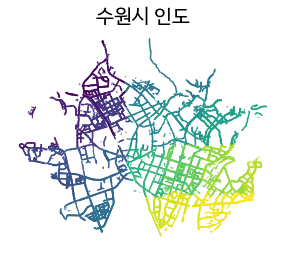

In [ ]:
ax = df_인도26.plot(column="UFID", cmap='viridis')
ax.set_title("수원시 인도", fontsize=20)
ax.set_axis_off()
plt.show()

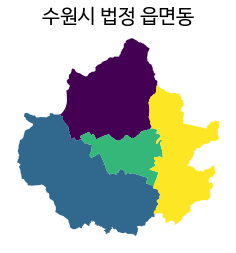

In [ ]:
ax = df_법정시군구29.plot(column="SIG_CD", cmap='viridis')
ax.set_title("수원시 법정 읍면동", fontsize=20)
ax.set_axis_off()
plt.show()

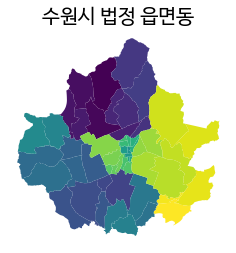

In [ ]:
ax = df_법정읍면동30.plot(column="EMD_CD", cmap='viridis')
ax.set_title("수원시 법정 읍면동", fontsize=20)
ax.set_axis_off()
plt.show()

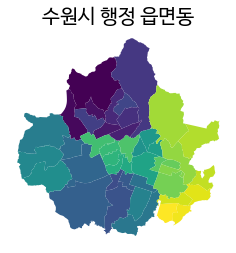

In [ ]:
ax = df_행정읍면동31.plot(column="ADM_DR_CD", cmap='viridis')
ax.set_title("수원시 행정 읍면동", fontsize=20)
ax.set_axis_off()
plt.show()

### 시각화 - pydeck ; Colab 작동 X(jupyter에서 사용)

In [ ]:
# pydeck은 Colab 지원 X -> Jupyter notebook 사용
# https://compas.lh.or.kr/subj/past/code?subjNo=SBJ_2009_001&teamNo=677
# 광양시 전기자동차 충전소
# Make layer
# 사람이 있는 그리드만 추출
layer = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
                  df_popul[(df_popul['val'].isnull()==False) & df_popul['val']!=0], # 시각화에 쓰일 데이터프레임 
                  get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름 
                  get_fill_color='[0, 255*정규화인구, 0, 정규화인구*10000 ]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
                  pickable=True, # 지도와 interactive 한 동작 on 
                  auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
                 ) 

# Set the viewport location 
center = [127.696280, 34.940640] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=10
) 

# Render 
r = pdk.Deck(layers=[layer], 
             initial_view_state=view_state,
             map_style='mapbox://styles/mapbox/dark-v9', 
             api_keys='pk.eyJ1IjoianVuZ3dvbjY0MiIsImEiOiJja2x0aHYwc3UwM2hpMm5uNjF2cnRxMmlyIn0.f795wWCq-p1kAZBvoZL2Ww'
            #  map_style='mapbox://styles/mapbox/outdoors-v11'
            )
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)
# r.to_html()

r.show()

### 시각화 - folium; CircularBinning으로 json, to_crs, to_json

In [ ]:
json = CircularBinning(features="geoband:gvi_busan", weight="greenview",
                        csr="EPSG:4326", minX="128.7617", minY="34.9891", maxX="129.3056", maxY="35.389",
                        radius="0.05", validGrid="False", saveFileName="json/result_CircularBinning.json")
gdf = gpd.read_file('json/result_CircularBinning.json')

In [ ]:
gdf = gdf.to_crs(epsg='4326')
converted_json = gdf.to_json()

m = folium.Map(
    location=[35.1598,129.0001],
    zoom_start=10
)

folium.GeoJson(
    converted_json,
).add_to(m)

m